In [37]:
import os
from glob import glob
from PIL import Image
import base64
from tqdm import tqdm_notebook


import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [38]:
len(os.listdir('VOCdevkit/VOC2007/JPEGImages'))

9963

In [39]:
len(os.listdir('VOCdevkit/VOC2007/SegmentationObject'))

632

In [40]:
image_paths = glob('VOCdevkit/VOC2007/JPEGImages/*.jpg')
label_paths = glob('VOCdevkit/VOC2007/SegmentationClass/*.png')

In [41]:
image_names = [ x.split('\\')[-1].split('.')[0] for x in image_paths ]
segment_names = [ x.split('\\')[-1].split('.')[0] for x in label_paths ]
segment_names[:5] , image_names[:5]

(['000032', '000033', '000039', '000042', '000061'],
 ['000001', '000002', '000003', '000004', '000005'])

In [42]:
for path in tqdm_notebook(label_paths):
    new_dir = os.path.join(os.path.dirname(path), 'new_folder')
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    label = np.array(Image.open(path))
    new_label = Image.fromarray(label)
    new_path = os.path.join(new_dir, os.path.basename(path))
    new_label.save(new_path)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [43]:
new_image_paths = []
for segment_name in segment_names :
    if segment_name in image_names :
        new_image_paths.append(os.path.join('VOCdevkit/VOC2007/JPEGImages\\',(segment_name+'.jpg')))

In [44]:
len(new_image_paths) , new_image_paths[:5]

(632,
 ['VOCdevkit/VOC2007/JPEGImages\\000032.jpg',
  'VOCdevkit/VOC2007/JPEGImages\\000033.jpg',
  'VOCdevkit/VOC2007/JPEGImages\\000039.jpg',
  'VOCdevkit/VOC2007/JPEGImages\\000042.jpg',
  'VOCdevkit/VOC2007/JPEGImages\\000061.jpg'])

이제 하나로 합쳤고, 클래스가 몇개 있는지 확인해보자

In [45]:
def class_num(lbl_paths) :
    print(len(lbl_paths))
    class_unique = []
    for lbl_path in lbl_paths :

        label_classes = np.unique(np.array(Image.open(lbl_path)))
        for label_class in label_classes :
            if label_class not in class_unique :
                class_unique.append(label_class)
    return class_unique

In [46]:
class_unique = class_num(label_paths)
class_nums = len(class_unique)

632


In [47]:
class_nums

22

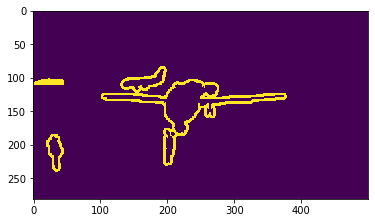

In [48]:
# class num 255는 어떤걸까? 확인해보자
path =  np.array(Image.open(label_paths[0]))
path = np.where(path == 255, 1 , 0)
plt.imshow(path)

In [49]:
batch_size = 4
epochs = 5
drop_rate = 0.2

input_shape = (128, 128, 3)

In [50]:
## 이건 그냥 학습용 으로 올려둔겁니다 아래에 고친 함수가 새로 있습니다.


def data_preprocess(img_path, lbl_path):
    image_tf = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image_tf) / 255
    image = tf.image.resize(image, input_shape[:2])
    
    label_tf = tf.io.read_file(lbl_path)
    label = tf.io.decode_png(label_tf)

    label_c, _ = tf.split(label, [1, -1], axis=-1)
    
    # 아까 위에서 본 테두리를 없애는 과정?
    label_c = tf.where(label_c == 255 , tf.zeros_like(0, dtype=tf.uint8), label_c)
    
    
    label_c = tf.image.resize(label_c, input_shape[:2], 'nearest')
    label = tf.squeeze(label_c)    
    label_onehot = tf.one_hot(label, class_nums)
    return image, label_onehot

위의 것으로도학습이 돌아가긴 한다, 하지만!!! 문제는,, PIL 로 읽는 것과 tensorflow 가 읽는 값이 다르다고한다. 아래와 결과를 보자

In [51]:
label_tf = tf.io.read_file(label_paths[0])
label = tf.io.decode_png(label_tf)

print(label.shape)
label_c, _ = tf.split(label, [1, -1], axis=-1)

# 아까 위에서 본 테두리를 없애는 과정?

label_c = tf.where(label_c == 255 , tf.zeros_like(0, dtype=tf.uint8), label_c)
print(np.unique(label_c))

label_c = tf.image.resize(label_c, input_shape[:2], 'nearest')
label = tf.squeeze(label_c)    
label_onehot = tf.one_hot(label, class_nums)


(281, 500, 3)
[  0 128 192 224]


0, 128, 192, 224 ?? 테두리값 255는 어디갔고 또 옆에 값들은 무엇인가??.. 심지어 shape를 보면 채널이 3개이다 ㅠㅠ 이런 시련이,,, 그래서 아래와 같이 좀 복잡하게 값을 불러와야 한다.

In [52]:
def data_preprocess(img_path, lbl_path):
    image_tf = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image_tf) / 255
    image = tf.image.resize(image, input_shape[:2])
    
    png_bytes = tf.io.read_file(label_paths[0])
    label = tf.py_function(lambda bytes: np.array(Image.open(label_paths[0])),[png_bytes], tf.uint8)
    
    # 이전것과는 다르게 shape이 (281,500,1) 이 아닌 (281,500) 으로 나오므로 reshape해줘야 한다.
    label_c = tf.reshape(label, [281,500,1])

    # 아까 위에서 본 테두리를 없애는 과정?
    label_c = tf.where(label_c == 255 , tf.zeros_like(0, dtype=tf.uint8), label_c)
    label_c = tf.image.resize(label_c, input_shape[:2], 'nearest')
    label = tf.squeeze(label_c)    

    label_onehot = tf.one_hot(label, class_nums-1)
    return image, label_onehot

In [53]:
dataset = tf.data.Dataset.from_tensor_slices((new_image_paths, label_paths))
dataset = dataset.map(data_preprocess)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(10)
dataset = dataset.repeat()

In [54]:
image,label = next(iter(dataset))
image.shape, label.shape

(TensorShape([4, 128, 128, 3]), TensorShape([4, 128, 128, 21]))

## UNET Modeling

In [26]:
# Build UNet
inputs = layers.Input(input_shape)
conv1 = layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation("relu")(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Activation("relu")(conv2)
conv2 = layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Activation("relu")(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Activation("relu")(conv3)
conv3 = layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Activation("relu")(conv3)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = layers.BatchNormalization()(conv4)
conv4 = layers.Activation("relu")(conv4)
conv4 = layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = layers.BatchNormalization()(conv4)
conv4 = layers.Activation("relu")(conv4)
drop4 = layers.Dropout(drop_rate)(conv4)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = layers.Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = layers.BatchNormalization()(conv5)
conv5 = layers.Activation("relu")(conv5)
conv5 = layers.Conv2D(1024, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = layers.BatchNormalization()(conv5)
conv5 = layers.Activation("relu")(conv5)
drop5 = layers.Dropout(drop_rate)(conv5)

up6 = layers.Conv2DTranspose(1024, 2, padding='same', strides=(2, 2))(drop5)
merge6 = layers.concatenate([drop4, up6], axis=3)
conv6 = layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = layers.BatchNormalization()(conv6)
conv6 = layers.Activation("relu")(conv6)
conv6 = layers.Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = layers.BatchNormalization()(conv6)
conv6 = layers.Activation("relu")(conv6)

up7 = layers.Conv2DTranspose(512, 2, padding='same', strides=(2, 2))(conv6)
merge7 = layers.concatenate([conv3, up7], axis=3)
conv7 = layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = layers.BatchNormalization()(conv7)
conv7 = layers.Activation("relu")(conv7)
conv7 = layers.Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = layers.BatchNormalization()(conv7)
conv7 = layers.Activation("relu")(conv7)

up8 = layers.Conv2DTranspose(256, 2, padding='same', strides=(2, 2))(conv7)
merge8 = layers.concatenate([conv2, up8], axis=3)
conv8 = layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = layers.BatchNormalization()(conv8)
conv8 = layers.Activation("relu")(conv8)
conv8 = layers.Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = layers.BatchNormalization()(conv8)
conv8 = layers.Activation("relu")(conv8)

up9 = layers.Conv2DTranspose(128, 2, padding='same', strides=(2, 2))(conv8)
merge9 = layers.concatenate([conv1, up9], axis=3)
conv9 = layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = layers.BatchNormalization()(conv9)
conv9 = layers.Activation("relu")(conv9)
conv9 = layers.Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = layers.BatchNormalization()(conv9)
conv9 = layers.Activation("relu")(conv9)
conv9 = layers.Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = layers.Conv2D(class_nums, 1, activation = 'sigmoid')(conv9)

model = tf.keras.Model(inputs=inputs, outputs=conv10)

In [27]:
# Dice Coefficient
def precision(y_true, y_pred):
    axes = tuple(range(1, len(y_pred.shape)-1))
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axes)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axes)
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return K.mean(precision)


def recall(y_true, y_pred):
    axes = tuple(range(1, len(y_pred.shape)-1))
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axes)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axes)
    recall = true_positives / (possible_positives + K.epsilon())
    
    return K.mean(recall)

def dice(y_true, y_pred):
    epsilon=1e-6
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return K.mean(numerator / (denominator + epsilon))

def soft_dice_loss(y_true, y_pred):
    epsilon=1e-6
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return 1 - K.mean(numerator / (denominator + epsilon))

In [28]:
model.compile(loss=soft_dice_loss,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy', dice])

In [29]:
step_per_epochs = len(image_paths) // batch_size

model.fit(dataset, steps_per_epoch=step_per_epochs)

   9/2490 [..............................] - ETA: 1:13:11 - loss: 0.9524 - accuracy: 0.2069 - dice: 0.0476

KeyboardInterrupt: 

In [ ]:
new_dir = "new_label"
if not os.path.exists(new_dir):
    os.mkdir(new_dir)
for path in label_paths:
    label = np.array(Image.open(path))
    Image.fromarray(label).save(os.path.join(os.path.dirname(path), new_dir, os.path.basename(path)))